## Описание плана работы:
1. Оценить количество ботов, которые заходят на наш сайт, и их долю от всего трафика.
2. Определить, с каких источников и в какое время суток чаще всего заходят роботы.

In [1]:
import json 
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

params = {'metrics': 'ym:s:visits', #метрика  кол-во визитов
          'dimensions': 'ym:s:lastsignTrafficSource,ym:s:isRobot,ym:s:hour',  #группировка по источнику, робот/не робот и времени визита
          'date1': '2020-09-01',  
          'date2': '2020-10-31',     
          'ids': 30177909,
          'accuracy':'full',
          'limit':100000}

token = 'AgAAAAA0KiLCAAbXHBuhr5KrMk71lFo_wehL-w4'
headers = {'Authorization': 'OAuth ' + token}

response = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params, headers=headers)
metrica_data = response.json()


def getMetrikaDataInListOfDicts(metrika_data): #функция, которая избавляется от вложенных словарей 
    list_of_dicts = []
    dimensions_list = metrika_data['query']['dimensions'] 
    metrics_list = metrika_data['query']['metrics']
    for data_item in metrika_data['data']:
        d = {}
        for i,dimension in enumerate(data_item['dimensions']): # функция позволяет сделать цикл по списку, при этом возвращая сам элемент списка, а также его индекс в этом списке
            d[dimensions_list[i]] = dimension['name']
        for i,metric in enumerate(data_item['metrics']):
            d[metrics_list[i]] = metric
        list_of_dicts.append(d)
    return list_of_dicts

Создадим датафрейм с использованием нашей функции и переименуем для удобства столбцы 

In [2]:
metrika_list_of_dicts = getMetrikaDataInListOfDicts(metrica_data) 
metrika_df = pd.DataFrame(metrika_list_of_dicts)
metrika_df.columns = ['source','robot','hour','visits']
display(metrika_df.sample(5))

,source,robot,hour,visits
143,Link traffic,Robots,09:00,3.0
86,Direct traffic,Robots,17:00,15.0
82,Search engine traffic,Robots,01:00,16.0
24,Search engine traffic,Robots,14:00,94.0
27,Search engine traffic,People,07:00,91.0


Выделим датафрейм для роботов

In [3]:
robot_df = metrika_df[metrika_df['robot'] == 'Robots']
display(robot_df.head(5))

,source,robot,hour,visits
17,Search engine traffic,Robots,15:00,109.0
18,Search engine traffic,Robots,13:00,107.0
19,Search engine traffic,Robots,16:00,105.0
21,Search engine traffic,Robots,11:00,98.0
22,Search engine traffic,Robots,17:00,97.0


## 1. Оценим количество ботов, которые заходят на наш сайт, и их долю от всего трафика

In [4]:
sum_all = metrika_df['visits'].sum()
sum_robot = robot_df['visits'].sum()
percent_robot = sum_robot*100/sum_all
print('Кол-во всех визитов: {}'.format(sum_all))
print('Кол-во ботов: {}'.format(sum_robot))
print('Доля ботов от всего трафика: {:.1f}%'.format(percent_robot))

Кол-во всех визитов: 8835.0
Кол-во ботов: 1701.0
Доля ботов от всего трафика: 19.3%


Дополнительно рассчитаем долю роботов в зависимоти от источника

In [5]:
params2 = {'metrics': 'ym:s:robotPercentage', #метрика, которая считает долю роботов
          'dimensions': 'ym:s:lastsignTrafficSource',  #группировка по источнику
          'date1': '2020-09-01',  
          'date2': '2020-10-31',     
          'ids': 30177909,
          'accuracy':'full',
          'limit':100000}

response2 = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params2, headers=headers)
metrica_data2 = response2.json()

metrika_list_of_dicts = getMetrikaDataInListOfDicts(metrica_data2) 
metrika_df2 = pd.DataFrame(metrika_list_of_dicts)
metrika_df2.columns = ['source','robot']
display(metrika_df2)

,source,robot
0,Direct traffic,20.843672
1,Link traffic,19.614148
2,Search engine traffic,19.165286
3,Internal traffic,17.391304
4,Cached page traffic,16.666667
5,Social network traffic,11.157025
6,Recommendation system traffic,0.000000
7,Messenger traffic,0.000000


Больше всего роботов приходят из "Direct traffic", а меньше всего, то есть 0, из "Recommendation system traffic" и "Messenger traffic"

## 2. Определим, с каких источников и в какое время суток чаще всего заходят роботы

1. Для начала выявим из каких источников чаще всего заходят роботы и визуализируем данные 

<AxesSubplot:ylabel='source'>

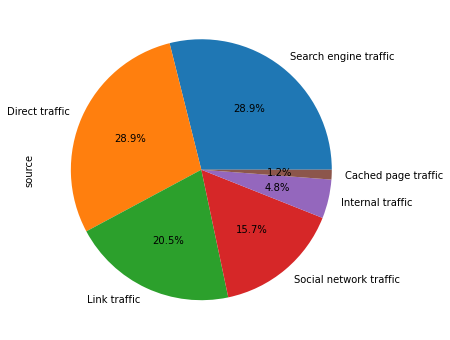

In [6]:
source_robots = robot_df['source'].value_counts()
source_robots.plot(kind = 'pie',figsize=(6,6), autopct='%1.1f%%')

Максимальные значения у "Direct traffic" 28.9%  и "Search engine traffic" 28.9%

2. Выявим в какое время суток чаще всего заходят роботы 

In [7]:
night = (robot_df.hour >= '00:00') & (robot_df.hour <= '12:00') #выделим параметры для ночной группы 
day = (robot_df.hour >= '13:00') & (robot_df.hour <= '23:00') #выделим параметры для дневной группы 

night_df = robot_df[night] #создадим новые датафреймы, учитывая новые параметры
day_df = robot_df[day]

visits_night = night_df['visits'].sum() #посчитаем кол-во визитов для каждой группы 
visits_day = day_df['visits'].sum()
dif = visits_day-visits_night
percent = dif/visits_day*100
print('Кол-во ночных визитов: {}'.format(visits_night))
print('Кол-во дневних визитов: {}'.format(visits_day))
print('Днем на {:.2f}% больше активности, чем ночью'.format(percent))

Кол-во ночных визитов: 615.0
Кол-во дневних визитов: 1086.0
Днем на 43.37% больше активности, чем ночью
